In [216]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [217]:
DATASET_PATH = "D:/new project taarlab/Dataset/"
blender_path = os.path.join(DATASET_PATH, "Blender/")
light_switch = os.path.join(DATASET_PATH, "Light_Switch/")
toaster = os.path.join(DATASET_PATH, "Toaster/")
water = os.path.join(DATASET_PATH, "Water/")

In [218]:
AUDIO_CLASSES = ["Blender", "Light_Switch", "Toaster", "Water"]

In [219]:
def save_as_numpy(X, y, output_path = "mfcc_features.npz"):
    np.savez(output_path, X = X, y = y)

In [220]:
from sklearn.utils import shuffle
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
def load_and_preprocess_audio(dataset_path, classes, sr=22050, n_mels=128, max_frames=216):
    X, y = [], []
    for idx, label in enumerate(classes):
        class_path = os.path.join(dataset_path, label)
        for file_name in os.listdir(class_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_path, file_name)
                audio, _ = librosa.load(file_path, sr=sr)
                mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                if mel_spec_db.shape[1] > max_frames:  
                    mel_spec_db = mel_spec_db[:, :max_frames]
                else:  
                    pad_width = max_frames - mel_spec_db.shape[1]
                    mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')

                X.append(mel_spec_db)
                y.append(idx)
                
    save_as_numpy(X, y)
    X = np.array(X)
    y = np.array(y)
    return X, y



X, y = load_and_preprocess_audio(DATASET_PATH, AUDIO_CLASSES)

y = to_categorical(y, num_classes=len(AUDIO_CLASSES))


X = X / np.max(X)
X = np.expand_dims(X, axis=-1)

print(f"size X: {X.shape}")
print(f"size y: {y.shape}")

X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"size X_train: {X_train.shape}")
print(f"size X_test: {X_test.shape}")


print(f"size Y_train: {y_train.shape}")
print(f"size Y_test: {y_test.shape}")


input_shape = X_train[0].shape
print(input_shape)
input_layer = Input(shape=input_shape)


conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2), padding = 'same')(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2, 2), padding = 'same')(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D((2, 2), padding = 'same')(conv3)

print("Shape before Flatten:", pool3.shape)

flat_input = tf.keras.layers.Reshape((-1,))(pool3)
flat = Flatten()(flat_input)
dense1 = Dense(128, activation='relu')(flat)
dense1 = Dropout(0.3)(dense1)
output_layer = Dense(len(AUDIO_CLASSES), activation='softmax')(dense1)

from sklearn.utils.class_weight import compute_class_weight

model = Model(inputs=input_layer, outputs=output_layer)

# class_weights = compute_class_weight("balanced", classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
# class_weights_dict = {i: class_weights[i] for i in range(len(AUDIO_CLASSES))}

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


layers = [conv1, pool1, conv2, pool2, conv3, pool3]
feature_extractor = Model(inputs = model.input, outputs = layers)

sample_features = feature_extractor.predict(np.expand_dims(X_test[0], axis=0))

for idx, feature_map in enumerate(sample_features):
    print(f"Layer {idx+1} output shape: {feature_map.shape}")


size X: (136, 128, 216, 1)
size y: (136, 4)
size X_train: (108, 128, 216, 1)
size X_test: (28, 128, 216, 1)
size Y_train: (108, 4)
size Y_test: (28, 4)
(128, 216, 1)
Shape before Flatten: (None, 16, 27, 128)
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.4512 - loss: 10.9222 - val_accuracy: 0.2857 - val_loss: 282.8076
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.7356 - loss: 6.6740 - val_accuracy: 0.2857 - val_loss: 416.6129
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.8440 - loss: 3.2445 - val_accuracy: 0.1786 - val_loss: 405.0763
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.9156 - loss: 5.1414 - val_accuracy: 0.1786 - val_loss: 541.2994
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.9303 - loss: 1.1780 - val_accuracy: 0.1786 - val_loss: 612.2614
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.9407 - loss: 1.2653 - val_accuracy: 0.1786 - val_loss: 578.9429
Epoch 7/50
4/4 ━━━━━━━━

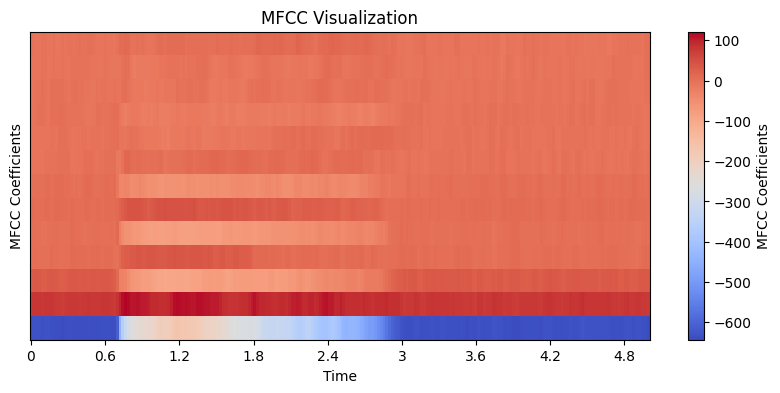

In [221]:
def plot_mfcc(file_path, sr=22050, n_mfcc=13):
    audio, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar(label='MFCC Coefficients')
    plt.title('MFCC Visualization')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.show()
    
plot_mfcc("D:/new project taarlab/Dataset/Blender/16.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


<Figure size 800x600 with 0 Axes>

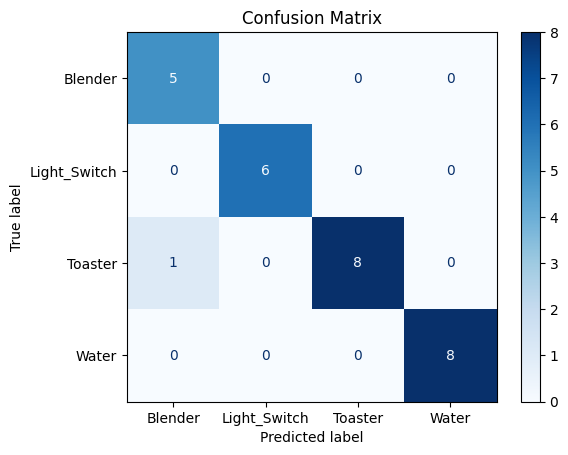

In [222]:
y_pred_probs = model.predict(X_test)  
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = np.argmax(y_test, axis=1)  


cm = metrics.confusion_matrix(y_true, y_pred)


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(cm, AUDIO_CLASSES)

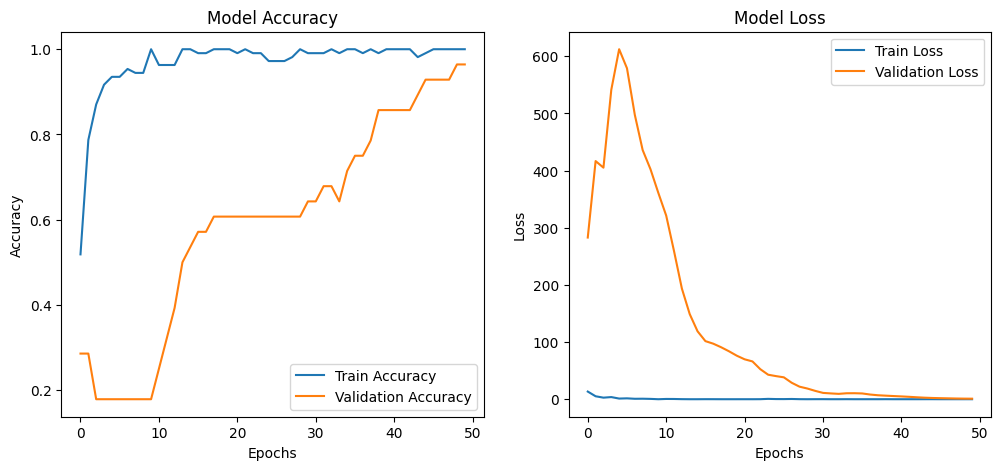

In [223]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [224]:
model.summary()

Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 216, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 128, 216, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128, 216, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     7,078,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,515,406 (82.07 MB)

 Trainable params: 7,171,652 (27.36 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 14,343,306 (54.72 MB)

In [225]:
from scipy.ndimage import zoom

def resize_feature_map(feature, target_shape):
    zoom_factors = [target / source for target, source in zip(target_shape, feature.shape)]
    return zoom(feature, zoom_factors, order=1)  # Linear interpolation


In [226]:
def extract_features(model, X, layers):
    feature_extractor = Model(inputs=model.input, outputs=layers)
    features = feature_extractor.predict(X)
    print("extracted feature shape: ", features[5].shape)
    return features

In [227]:
from scipy.spatial.distance import cdist

def check_similarity(features1, features2, similarity_method = "euclidean"):
    if features1.shape != features2.shape:
        features2 = resize_feature_map(features2, features1.shape)  # Resize to match
    # if similarity_method == "cosine":
    #     return 1 - cosine(features1.flatten(), features2.flatten())
    # elif similarity_method == "euclidean":
    #     return -np.linalg.norm(features1 - features2)
    
    features1 = features1.reshape(1, -1)
    features2 = features2.reshape(1, -1)
    
    distance = cdist(features1, features2, metric = similarity_method)
    return 1 - distance[0, 0]

In [228]:
def find_most_similar(features, layer_idx, feature_idx, metric="cosine"):
    print("layer_idx: ", layer_idx)
    print("feature_idx: ", feature_idx)
    reference_feature = features[layer_idx][feature_idx] #find the exact feature that we are working with right now
    similarities = []
    for j in range(len(features[layer_idx])):
        if j != feature_idx:
            candidate_feature = features[layer_idx][j]
            similarity = check_similarity(reference_feature, candidate_feature, metric)
            similarities.append((j, similarity))
    most_similar_idx, max_similarity = max(similarities, key = lambda x: x[1]) #
    return most_similar_idx, max_similarity

In [229]:
def compare_outputs(model, features, idx, most_similar_idx, self_idx):
    print(f"Shape of features[{idx}][{self_idx}]:", features[idx][self_idx].shape)
    print(f"Shape of features[{idx}][{most_similar_idx}]:", features[idx][most_similar_idx].shape)
    
    # original_feature = np.expand_dims(features[idx][self_idx], axis=0)
    # similar_feature = np.expand_dims(features[idx][most_similar_idx], axis=0)
    
    original_feature = features[idx][self_idx]
    similar_feature = features[idx][most_similar_idx]
    
    if original_feature.shape != similar_feature.shape:
        similar_feature = resize_feature_map(similar_feature, original_feature.shape)
    print(f"Shape after expand_dims: original={original_feature.shape}, similar={similar_feature.shape}")
    
    #check if expand dims is actually necessary
    original_feature = np.expand_dims(original_feature, axis=0)
    similar_feature = np.expand_dims(similar_feature, axis=0)
    
    original_output = model.predict(original_feature)
    similar_output = model.predict(similar_feature)
    return np.allclose(original_output, similar_output), original_output, similar_output

In [230]:
def calculate_seperation_index(seperation_idx, output):
    return (seperation_idx[output] + 1)

In [231]:
feature_layers = [conv1, pool1, conv2, pool2, conv3, pool3]


In [232]:
seperation_idx = [[0 for _ in range(6)] for _ in range(len(AUDIO_CLASSES))]

def analyze_features_and_outputs(model, X, feature_layers):
    
    features = extract_features(model, X, feature_layers)
    print(f"Extracted {len(features)} feature sets")
    results = []
    print(f"Number of feature sets extracted: {len(features)}") 
    for i, feature_set in enumerate(features):
        print(f"Feature set {i} has {len(feature_set)} layers")


    # seperation_idx = [output for i,output in enumerate(AUDIO_CLASSES)]

    for layer_idx, feature_set in enumerate(features):
        print(f"Layer {layer_idx} has {len(feature_set)} features")
        for feature_idx in range(len(feature_set)):
            
            most_similar_idx, similarity = find_most_similar(features, layer_idx, feature_idx) #idx shouldn't be passed on to this function or should be calculated 
            
            
            same_output, original_output, similar_output = compare_outputs(
                model, features, layer_idx, most_similar_idx, feature_idx
            )
            
            print("this is original output:", original_output)
            class_idx = np.argmax(original_output) #this is always returning 0
            
            if(same_output):
                print("yes, same output")
                seperation_idx[class_idx][layer_idx] += 1 #
            
            # results.append({
            #     "layer_idx": layer_idx,
            #     "feature_idx": feature_idx,
            #     "most_similar_idx": most_similar_idx,
            #     "similarity": similarity,
            #     "same_output": same_output,
            #     "original_output": original_output,
            #     "similar_output": similar_output
            # })
    
    return seperation_idx


In [233]:
print("Input shape:", X_train[0].shape)


Input shape: (128, 216, 1)


In [234]:
for layer in [conv1, pool1, conv2, pool2, conv3, pool3]:
    print(layer.name, "output shape:", layer.shape)


keras_tensor_138 output shape: (None, 128, 216, 32)
keras_tensor_139 output shape: (None, 64, 108, 32)
keras_tensor_141 output shape: (None, 64, 108, 64)
keras_tensor_142 output shape: (None, 32, 54, 64)
keras_tensor_144 output shape: (None, 32, 54, 128)
keras_tensor_145 output shape: (None, 16, 27, 128)


In [235]:
import matplotlib.pyplot as plt

def plot_SI_per_layer(seperation_idx, class_idx, layer_names):
    num_layers = len(layer_names)

    # Extract SI values for the selected class
    si_values = [seperation_idx[class_idx][layer] for layer in range(num_layers)]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(layer_names, si_values, marker='o', linestyle='-', color='b', label=f'Class {class_idx} SI')
    plt.xlabel("Layers")
    plt.ylabel("Separation Index")
    plt.title(f"Separation Index per Layer for Class {class_idx}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    
feature_layers = [conv1, pool1, conv2, pool2, conv3, pool3]
seperation_idx = analyze_features_and_outputs(model, X_test, feature_layers)


# for res in results:
#     print(f"Layer {res['layer_idx']} - Feature {res['feature_idx']} - Similarity: {res['similarity']:.4f} - Same Output: {res['same_output']}")
   
print("\nSeparation Index Matrix:")
for row in seperation_idx:
    print(row)
 
class_idx = 0
layer_names = ["conv1", "pool1", "conv2", "pool2", "conv3", "pool3"]
plot_SI_per_layer(seperation_idx, class_idx, layer_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


extracted feature shape:  (28, 16, 27, 128)
Extracted 6 feature sets
Number of feature sets extracted: 6
Feature set 0 has 28 layers
Feature set 1 has 28 layers
Feature set 2 has 28 layers
Feature set 3 has 28 layers
Feature set 4 has 28 layers
Feature set 5 has 28 layers
Layer 0 has 28 features
layer_idx:  0
feature_idx:  0
Shape of features[0][0]: (128, 216, 32)
Shape of features[0][7]: (128, 216, 32)
Shape after expand_dims: original=(128, 216, 32), similar=(128, 216, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
this is original output: [[0. 0. 0. 1.]]
yes, same output
layer_idx:  0
feature_idx:  1
Shape of features[0][1]: (128, 216, 32)
Shape of features[0][22]: (128, 216, 32)
Shape after expand_dims: original=(128, 216, 32), similar=(128, 216, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
this is original output: [[0. 0. 0. 1.]]
yes, same output
layer_idx:  0
feature_idx:  2
Shape of features[0][2]: (128, 216, 3

InvalidArgumentError: Graph execution error:

Detected at node functional_69_1/reshape_2_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\AsusIran\AppData\Local\Temp\ipykernel_20096\1911759805.py", line 23, in <module>

  File "C:\Users\AsusIran\AppData\Local\Temp\ipykernel_20096\1440234250.py", line 22, in analyze_features_and_outputs

  File "C:\Users\AsusIran\AppData\Local\Temp\ipykernel_20096\349553421.py", line 19, in compare_outputs

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 519, in predict

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 217, in one_step_on_data_distributed

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 206, in one_step_on_data

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 98, in predict_step

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\layers\layer.py", line 826, in __call__

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\models\functional.py", line 199, in call

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\models\functional.py", line 583, in call

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\layers\layer.py", line 826, in __call__

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\layers\reshaping\reshape.py", line 66, in call

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\ops\numpy.py", line 4527, in reshape

  File "c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1618, in reshape

Input to reshape is a tensor with 14336 values, but the requested shape has 55296
	 [[{{node functional_69_1/reshape_2_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_131805]